In this example project I will load in the CIFAR-10 dataset (Learning Multiple Layers of Features from tiny Images, Krizhevsky 2009), which consists of 60,000 32x32 color images of 10 classes. Using the 50,000 training images, I will build a small neural network classifier to predict the class label of images - ultimately to be tested on the 10,000 test images. 

For task context, the authors achieved 26% error on CIFAR-10 in 80 seconds (without image translations + transformations), 18% error in 20 minutes (without translations + transformations), and 11% in 75 minutes (with translations and reflections). Please see https://www.cs.toronto.edu/~kriz/cifar.html and https://code.google.com/archive/p/cuda-convnet/ for more.

In [20]:
# LOAD IN SOME IMAGE DATA TO WORK WITH
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import numpy as np
import math
from data_utils.data import load_CIFAR10

''' Load CIFAR-10 data and do some minor preprocessing '''
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=10000):

    # Load the raw CIFAR-10 data
    cifar10_dir = 'data_utils/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    return X_train, y_train, X_val, y_val, X_test, y_test


# Call above to get our data, print to make sure looks rights.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


In [21]:
# LETS BUILD A CLASSIFIER

''' Let us define a model. 
Here we will try a [conv-relu-pool] * N -> [affine-relu] * M -> softmax architecture.
'''
def my_model(X,y,is_training):
    N, M = 4, 2  # layer hyperparams
    filter_size, nchannels, nfilters = 5, 3, 32
    stride, pad = 1, 0
    pool_stride, pool_size = 2, 2
    hidden_dim, nclasses = 1024, 10
    xavier = tf.contrib.layers.xavier_initializer(dtype=tf.float64)
    dropout = 0.2
    
    data = X
    channels = nchannels
    for n in range(N):
        W, b, layer = "Wc%d" % (n+1), "bc%d" % (n+1), "Conv%d" % (n+1)
        with tf.variable_scope(layer):
            Wc = tf.get_variable(W, shape=[filter_size, filter_size, data.get_shape()[3], nfilters], initializer=xavier)
            tf.add_to_collection(tf.GraphKeys.REGULARIZATION_LOSSES, Wc)
            bc = tf.get_variable(b, shape=[nfilters], initializer=tf.constant_initializer(0))
            conv = tf.nn.conv2d(data, Wc, strides=[1,stride,stride,1], padding='SAME') + bc
            #conv_out_dim = int(1 + (int(data.shape[1]) + 2 * pad - filter_size) / stride)
            relu = tf.nn.relu(conv)
            norm = tf.contrib.layers.batch_norm(relu, center=True, scale=True)
            pool = tf.nn.max_pool(norm, [1,pool_size,pool_size,1], strides=[1,pool_stride,pool_stride,1], padding='VALID')
            #pool_out_dim = int((conv_out_dim - pool_size)/pool_stride + 1)
            data = pool
    
    #aff_input_dim = pool_out_dim*pool_out_dim*nfilters
    aff_input_dim = int(data.get_shape()[1])**2 * nfilters
    for m in range(M):
        W, b, layer = "Wa%d" % (m+1), "ba%d" % (m+1), "Affine%d" % (m+1)
        with tf.variable_scope(layer):
            Wa = tf.get_variable(W, shape=[aff_input_dim, hidden_dim], initializer=xavier)
            tf.add_to_collection(tf.GraphKeys.REGULARIZATION_LOSSES, Wa)
            ba = tf.get_variable(b, shape=[hidden_dim], initializer=tf.constant_initializer(0))
            data_flat = tf.reshape(data, [-1, aff_input_dim])
            aff = tf.matmul(data_flat, Wa) + ba
            relu = tf.nn.relu(aff)
            data = tf.contrib.layers.batch_norm(relu, center=True, scale=True)
            aff_input_dim = hidden_dim
    
    with tf.variable_scope("Affine_final"):
        Wf = tf.get_variable("W_final", shape=[aff_input_dim, nclasses], initializer=xavier)
        tf.add_to_collection(tf.GraphKeys.REGULARIZATION_LOSSES, Wf)
        bf = tf.get_variable("b_final", shape=[nclasses], initializer=tf.constant_initializer(0))
        data_flat = tf.reshape(data,[-1,aff_input_dim])
        y_out = tf.matmul(data_flat, Wf) + bf
        return y_out

# clear old variables
tf.reset_default_graph()

# define input 
X = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)
y_out = my_model(X,y,is_training)

regularizer = tf.contrib.layers.l2_regularizer(scale=1e-2)
reg_variables = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
reg_term = tf.contrib.layers.apply_regularization(regularizer, reg_variables)

mean_loss = tf.contrib.losses.sparse_softmax_cross_entropy(labels=y, logits=y_out) + reg_term
global_step = tf.Variable(0, trainable=False)
starter_learning_rate = 1e-3
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step, 2000, 0.96, staircase=True)
optimizer = tf.train.AdamOptimizer(learning_rate)

# for batch normalization
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss, global_step=global_step)
pass


To begin with I implemented a model with the following architecture conv-relu-pool -> affine-relu -> final affine (FC) -> softmax. The resulting training accuracy rose quickly which was promising, however it was not reaching the levels I wanted. Hence, I added to the model's complexity as follows [conv-relu-pool] * N -> [affine-relu] * M -> final affine -> softmax, testing various hyperparameter values of M and N. 

Using M=2 and N=2 the model was able to achieve very strong training accuracy, however it was overfitting to the data as the validation accuracy still lagged. As a result, I decided to implement a learning rate decay for my Adam optimizer as well as regularize my loss. With these two additions, whose hyperparamters I settled on a decay of 0.96 every 3000 iterations and a l2-regularizer of scale 0.01 respectively, the validation accuracy followed much more closely to the training accuracy.

Ultimately, this allowed me to achieve > 70% validation accuracy after training for 10 epochs (as below) which compared quite nicely to the 74% SOTA "quick" baseline accuracy.

Training
Iteration 0: with minibatch training loss = 10.3 and accuracy of 0.031
Iteration 100: with minibatch training loss = 6.82 and accuracy of 0.41
Iteration 200: with minibatch training loss = 4.85 and accuracy of 0.44
Iteration 300: with minibatch training loss = 3.85 and accuracy of 0.42
Iteration 400: with minibatch training loss = 2.87 and accuracy of 0.55
Iteration 500: with minibatch training loss = 2.44 and accuracy of 0.56
Iteration 600: with minibatch training loss = 2.08 and accuracy of 0.55
Iteration 700: with minibatch training loss = 2.08 and accuracy of 0.55
Epoch 1, Overall loss = 4.01 and accuracy of 0.467


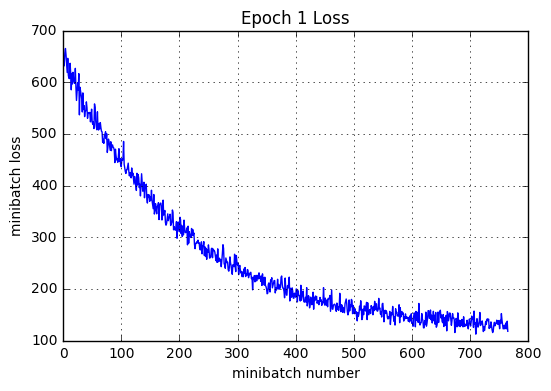

Iteration 800: with minibatch training loss = 2.16 and accuracy of 0.56
Iteration 900: with minibatch training loss = 1.93 and accuracy of 0.61
Iteration 1000: with minibatch training loss = 1.66 and accuracy of 0.64
Iteration 1100: with minibatch training loss = 1.93 and accuracy of 0.58
Iteration 1200: with minibatch training loss = 1.83 and accuracy of 0.52
Iteration 1300: with minibatch training loss = 1.66 and accuracy of 0.62
Iteration 1400: with minibatch training loss = 1.48 and accuracy of 0.64
Iteration 1500: with minibatch training loss = 1.7 and accuracy of 0.59
Epoch 2, Overall loss = 1.7 and accuracy of 0.597


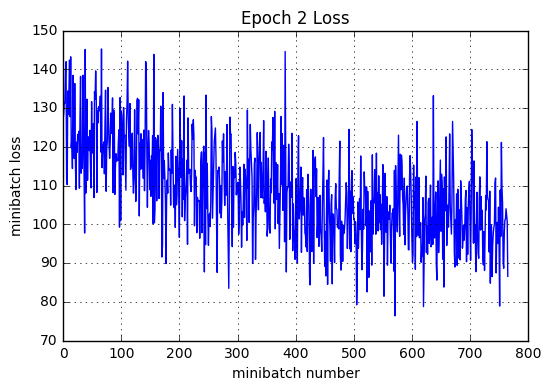

Iteration 1600: with minibatch training loss = 1.5 and accuracy of 0.62
Iteration 1700: with minibatch training loss = 1.66 and accuracy of 0.61
Iteration 1800: with minibatch training loss = 1.54 and accuracy of 0.66
Iteration 1900: with minibatch training loss = 1.58 and accuracy of 0.66
Iteration 2000: with minibatch training loss = 1.48 and accuracy of 0.61
Iteration 2100: with minibatch training loss = 1.31 and accuracy of 0.64
Iteration 2200: with minibatch training loss = 1.2 and accuracy of 0.72
Epoch 3, Overall loss = 1.43 and accuracy of 0.654


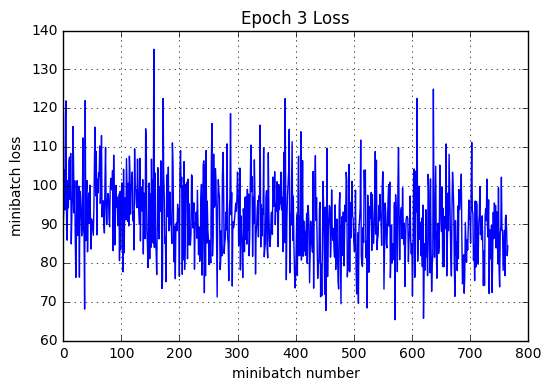

Iteration 2300: with minibatch training loss = 1.43 and accuracy of 0.56
Iteration 2400: with minibatch training loss = 1.43 and accuracy of 0.64
Iteration 2500: with minibatch training loss = 1.54 and accuracy of 0.64
Iteration 2600: with minibatch training loss = 1.17 and accuracy of 0.75
Iteration 2700: with minibatch training loss = 1.34 and accuracy of 0.7
Iteration 2800: with minibatch training loss = 1.14 and accuracy of 0.73
Iteration 2900: with minibatch training loss = 1.13 and accuracy of 0.77
Iteration 3000: with minibatch training loss = 1.48 and accuracy of 0.69
Epoch 4, Overall loss = 1.32 and accuracy of 0.684


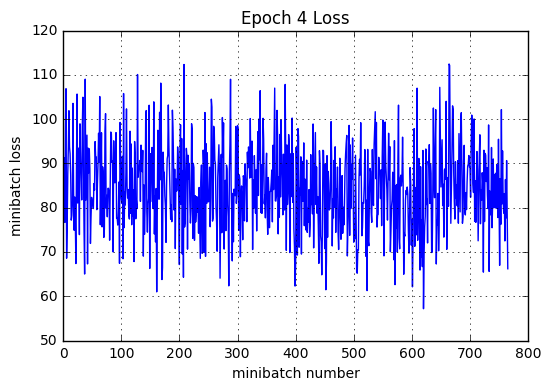

Iteration 3100: with minibatch training loss = 1.14 and accuracy of 0.72
Iteration 3200: with minibatch training loss = 1.44 and accuracy of 0.64
Iteration 3300: with minibatch training loss = 1.13 and accuracy of 0.75
Iteration 3400: with minibatch training loss = 1.14 and accuracy of 0.75
Iteration 3500: with minibatch training loss = 1.35 and accuracy of 0.77
Iteration 3600: with minibatch training loss = 1.38 and accuracy of 0.7
Iteration 3700: with minibatch training loss = 1.25 and accuracy of 0.69
Iteration 3800: with minibatch training loss = 1.15 and accuracy of 0.72
Epoch 5, Overall loss = 1.28 and accuracy of 0.7


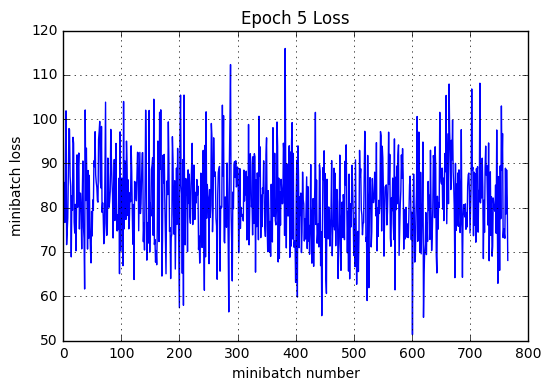

Iteration 3900: with minibatch training loss = 1.05 and accuracy of 0.84
Iteration 4000: with minibatch training loss = 1.2 and accuracy of 0.75
Iteration 4100: with minibatch training loss = 1 and accuracy of 0.81
Iteration 4200: with minibatch training loss = 1.04 and accuracy of 0.78
Iteration 4300: with minibatch training loss = 1.2 and accuracy of 0.77
Iteration 4400: with minibatch training loss = 1.46 and accuracy of 0.67
Iteration 4500: with minibatch training loss = 1.45 and accuracy of 0.7
Epoch 6, Overall loss = 1.23 and accuracy of 0.719


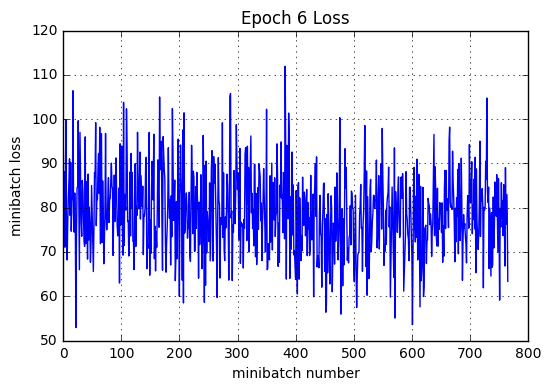

Iteration 4600: with minibatch training loss = 1.33 and accuracy of 0.66
Iteration 4700: with minibatch training loss = 1.33 and accuracy of 0.66
Iteration 4800: with minibatch training loss = 1.15 and accuracy of 0.77
Iteration 4900: with minibatch training loss = 1.35 and accuracy of 0.7
Iteration 5000: with minibatch training loss = 1.41 and accuracy of 0.64
Iteration 5100: with minibatch training loss = 1.04 and accuracy of 0.81
Iteration 5200: with minibatch training loss = 1.17 and accuracy of 0.75
Iteration 5300: with minibatch training loss = 1.35 and accuracy of 0.66
Epoch 7, Overall loss = 1.19 and accuracy of 0.732


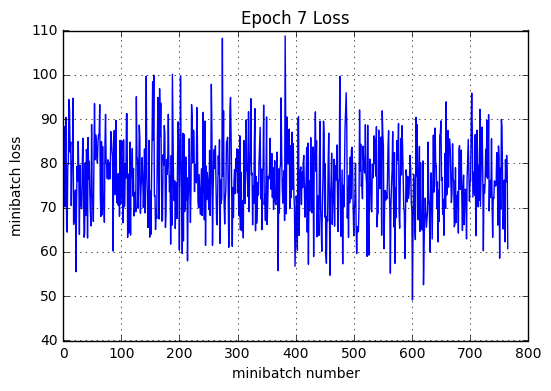

Iteration 5400: with minibatch training loss = 1.25 and accuracy of 0.73
Iteration 5500: with minibatch training loss = 0.984 and accuracy of 0.78
Iteration 5600: with minibatch training loss = 1.26 and accuracy of 0.72
Iteration 5700: with minibatch training loss = 1.2 and accuracy of 0.75
Iteration 5800: with minibatch training loss = 0.973 and accuracy of 0.78
Iteration 5900: with minibatch training loss = 1.17 and accuracy of 0.77
Iteration 6000: with minibatch training loss = 1.16 and accuracy of 0.75
Iteration 6100: with minibatch training loss = 1 and accuracy of 0.8
Epoch 8, Overall loss = 1.15 and accuracy of 0.742


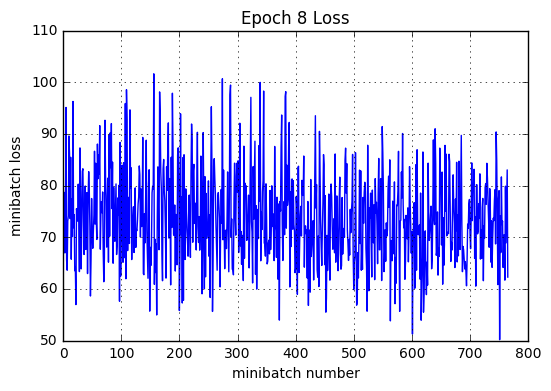

Iteration 6200: with minibatch training loss = 1.28 and accuracy of 0.62
Iteration 6300: with minibatch training loss = 1.31 and accuracy of 0.7
Iteration 6400: with minibatch training loss = 1.29 and accuracy of 0.72
Iteration 6500: with minibatch training loss = 0.847 and accuracy of 0.91
Iteration 6600: with minibatch training loss = 1.18 and accuracy of 0.75
Iteration 6700: with minibatch training loss = 1.1 and accuracy of 0.75
Iteration 6800: with minibatch training loss = 1.16 and accuracy of 0.73
Epoch 9, Overall loss = 1.11 and accuracy of 0.751


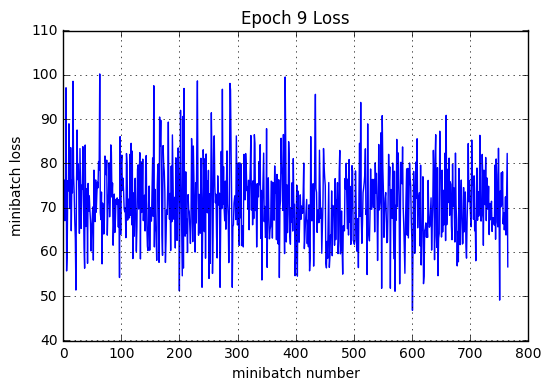

Iteration 6900: with minibatch training loss = 0.982 and accuracy of 0.75
Iteration 7000: with minibatch training loss = 1.05 and accuracy of 0.77
Iteration 7100: with minibatch training loss = 1.37 and accuracy of 0.62
Iteration 7200: with minibatch training loss = 1.17 and accuracy of 0.72
Iteration 7300: with minibatch training loss = 0.905 and accuracy of 0.81
Iteration 7400: with minibatch training loss = 0.902 and accuracy of 0.88
Iteration 7500: with minibatch training loss = 0.917 and accuracy of 0.8
Iteration 7600: with minibatch training loss = 0.98 and accuracy of 0.75
Epoch 10, Overall loss = 1.08 and accuracy of 0.76


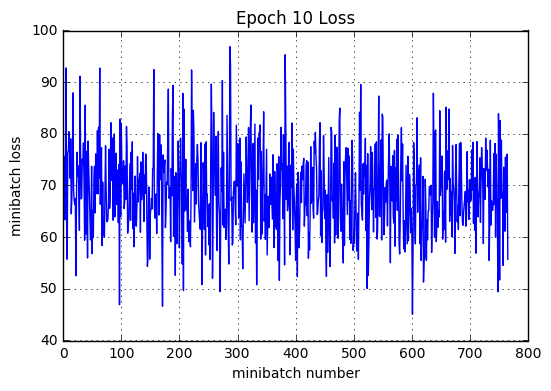

Validation
Epoch 1, Overall loss = 1.19 and accuracy of 0.732


In [22]:
# LETS TRAIN OUR MODEL

def run_model(session, predict, loss_val, Xd, yd, epochs=1, batch_size=64, print_every=100, training=None, plot_losses=False):
    
    # compute accuracy
    correct_prediction = tf.equal(tf.argmax(predict,1), y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # shuffle indicies
    train_indicies = np.arange(Xd.shape[0])
    np.random.shuffle(train_indicies)

    training_now = training is not None
    
    # variables we want to compute
    # if have a training function, add that to things we compute
    variables = [mean_loss,correct_prediction,accuracy]
    if training_now: variables[-1] = training
    
    # counter 
    iter_cnt = 0
    for e in range(epochs):
        # keep track of losses and accuracy
        correct = 0
        losses = []
        # make sure we iterate over the dataset once
        for i in range(int(math.ceil(Xd.shape[0]/batch_size))):
            # generate indicies for the batch
            start_idx = (i*batch_size)%X_train.shape[0]
            idx = train_indicies[start_idx:start_idx+batch_size]
            
            # create a feed dictionary for this batch
            feed_dict = {X: Xd[idx,:], y: yd[idx], is_training: training_now }
            # get batch size
            actual_batch_size = yd[i:i+batch_size].shape[0]
            
            # have tensorflow compute loss and correct predictions
            # and (if given) perform a training step
            loss, corr, _ = session.run(variables,feed_dict=feed_dict)
            
            # aggregate performance stats
            losses.append(loss*actual_batch_size)
            correct += np.sum(corr)
            
            # print every now and then
            if training_now and (iter_cnt % print_every) == 0:
                print("Iteration {0}: with minibatch training loss = {1:.3g} and accuracy of {2:.2g}"\
                      .format(iter_cnt,loss,np.sum(corr)/actual_batch_size))
            iter_cnt += 1
        total_correct = correct/Xd.shape[0]
        total_loss = np.sum(losses)/Xd.shape[0]
        print("Epoch {2}, Overall loss = {0:.3g} and accuracy of {1:.3g}"\
              .format(total_loss,total_correct,e+1))
        if plot_losses:
            plt.plot(losses)
            plt.grid(True)
            plt.title('Epoch {} Loss'.format(e+1))
            plt.xlabel('minibatch number')
            plt.ylabel('minibatch loss')
            plt.show()
    return total_loss,total_correct

# Creates a session and trains model for 1 epoch/s then prints the val set accuracy
sess = tf.Session()
sess.run(tf.global_variables_initializer())
print('Training')
run_model(sess,y_out,mean_loss,X_train,y_train,10,64,100,train_step,True)
print('Validation')
run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

With a final training accuracy of 76% and a validation set accuracy of over 73% (remember quick baseline was 74%) I was content with the performance of model. Moved on to final testing!

In [25]:
# GIVEN GOOD SCORES ABOVE ON VAL SET, LET'S FINISH UP

# One-time on the test set, our final accuracy!
print('Test')
run_model(sess,y_out,mean_loss,X_test,y_test,1,64)

Test
Epoch 1, Overall loss = 1.24 and accuracy of 0.709


(1.2426452312469483, 0.70920000000000005)

Now, we see that our val accuracy was a few points higher than our test accuracy but nevertheless > 70% seems to be a reasonable score. Going forward I think it would be fairly easy to boost that number to the 75%+ range through more advanced networks but for the purposes of this example I hope that will suffice!